findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

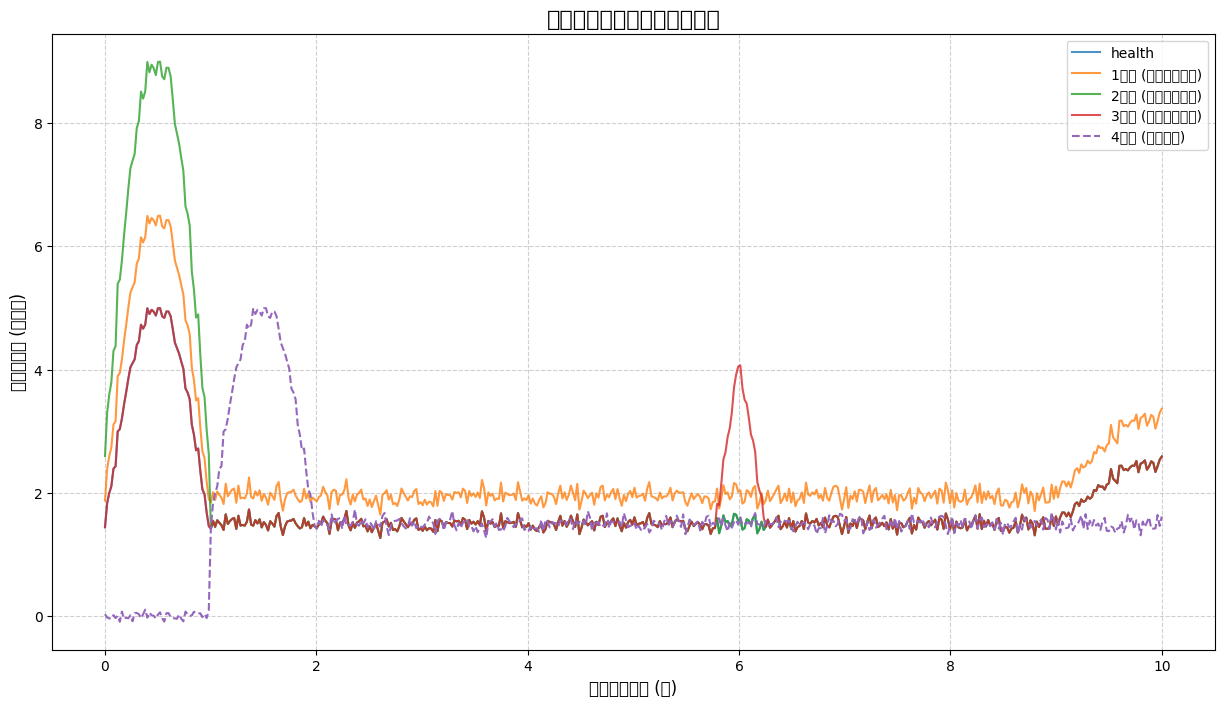

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from typing import Dict

# 设置中文字体，确保图表中的中文标签能正确显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def create_healthy_signal(points: int = 500) -> (np.ndarray, np.ndarray):
    """
    生成一个模拟的、健康的阀门投退过程扭矩信号。
    这个信号包含三个典型部分：
    1. 初始破封扭矩 (Breakaway Torque): 一个较高的初始峰值。
    2. 运行扭矩 (Running Torque): 一个相对平稳的中间阶段。
    3. 最终入封扭矩 (Seating Torque): 一个末尾的小幅升高。
    """
    time_axis = np.linspace(0, 10, points)
    torque = np.zeros(points)

    # 1. 初始破封峰值 (前10%的时间)
    p1_end = int(points * 0.1)
    breakaway_peak = 3.5
    torque[:p1_end] = breakaway_peak * np.sin(np.linspace(0, np.pi, p1_end)) + 1.5

    # 2. 运行扭矩 (10%到90%的时间)
    p2_start = p1_end
    p2_end = int(points * 0.9)
    running_torque_level = 1.5
    torque[p2_start:p2_end] = running_torque_level

    # 3. 最终入封扭矩 (最后10%的时间)
    p3_start = p2_end
    seating_peak = 1.0
    torque[p3_start:] = running_torque_level + seating_peak * np.sin(np.linspace(0, np.pi/2, points - p3_start))

    # 添加一些随机噪声，使其更真实
    noise = np.random.normal(0, 0.08, points)
    healthy_torque = torque + noise
    
    return time_axis, healthy_torque

def simulate_deformation(healthy_torque: np.ndarray) -> np.ndarray:
    """
    模拟因“变形”导致的故障。
    方法：将整个信号幅值按比例放大，模拟全局摩擦力增加。
    """
    # 假设摩擦力全局增加30%
    scaling_factor = 1.3
    return healthy_torque * scaling_factor

def simulate_aging(healthy_torque: np.ndarray) -> np.ndarray:
    """
    模拟因“老化”导致的故障。
    方法：显著放大初始“破封”峰值，模拟静摩擦力剧增。
    """
    faulty_torque = healthy_torque.copy()
    points = len(healthy_torque)
    
    # 识别破封峰值区域 (前10%) 并将其放大
    peak_end_index = int(points * 0.1)
    # 假设破封峰值所需扭矩增加80%
    faulty_torque[:peak_end_index] = faulty_torque[:peak_end_index] * 1.8 
    return faulty_torque

def simulate_loosening(healthy_torque: np.ndarray) -> np.ndarray:
    """
    模拟因“松动”导致的故障。
    方法：在信号起始处插入一段时延，模拟驱动空程。
    """
    faulty_torque = np.zeros_like(healthy_torque)
    points = len(healthy_torque)
    
    # 假设有50个数据点(1秒)的延迟
    delay_points = int(points * 0.1)
    
    # 延迟期间扭矩很低
    faulty_torque[:delay_points] = np.random.normal(0, 0.05, delay_points)
    
    # 延迟结束后，开始健康信号的波形
    faulty_torque[delay_points:] = healthy_torque[:points - delay_points]
    
    return faulty_torque

def simulate_sticking(healthy_torque: np.ndarray) -> np.ndarray:
    """
    模拟因“卡滞”导致的故障。
    方法：在行程中途叠加一个瞬时脉冲，模拟克服卡点。
    """
    faulty_torque = healthy_torque.copy()
    points = len(healthy_torque)
    
    # 假设在60%处发生卡滞
    sticking_point = int(points * 0.6)
    spike_width = int(points * 0.05)
    spike_height = 2.5
    
    # 创建一个三角脉冲
    spike = np.concatenate([
        np.linspace(0, spike_height, spike_width // 2),
        np.linspace(spike_height, 0, spike_width - spike_width // 2)
    ])
    
    # 叠加脉冲
    start_index = sticking_point - spike_width // 2
    end_index = start_index + spike_width
    faulty_torque[start_index:end_index] += spike
    
    return faulty_torque

def plot_signals(time_axis: np.ndarray, signals: Dict[str, np.ndarray]):
    """
    将所有信号绘制在一张图上进行对比。
    """
    plt.figure(figsize=(15, 8))
    
    for label, signal in signals.items():
        if "松动" in label: # 对松动信号做虚线处理以突出显示
             plt.plot(time_axis, signal, label=label, linestyle='--')
        else:
             plt.plot(time_axis, signal, label=label, alpha=0.8)

    plt.title("基于健康信号的投退失效仿真", fontsize=16)
    plt.xlabel("投退过程时间 (秒)", fontsize=12)
    plt.ylabel("执行器扭矩 (归一化)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


if __name__ == '__main__':
    # 1. 生成基础的健康信号
    time_axis, healthy_signal = create_healthy_signal()
    
    # 2. 基于健康信号模拟各种故障信号
    deformation_signal = simulate_deformation(healthy_signal)
    aging_signal = simulate_aging(healthy_signal)
    loosening_signal = simulate_loosening(healthy_signal)
    sticking_signal = simulate_sticking(healthy_signal)
    
    # 3. 准备绘图数据
    signals_to_plot = {
        "health": healthy_signal,
        "1变形 (全局幅值增加)": deformation_signal,
        "2老化 (初始峰值剧增)": aging_signal,
        "3卡滞 (中途瞬时脉冲)": sticking_signal,
        "4松动 (起始时延)": loosening_signal,
    }
    
    # 4. 绘图展示
    plot_signals(time_axis, signals_to_plot)